# Introduction

In this notebook I am going to develop a simple dual-loop feedback control system to balance and direct a bicycle. During the process of developing the controller, I will highlight some of the interesting dynamics and control properties of the vehicle. In particular, a bicycle requires control to both balance and direct the vehicle so I will use two feedback loops to address this. Control through steering is, in general, the primary input that has the most control authority. The steering lets the rider position the wheel contact points under the center of mass, very much like when balancing a stick on your hand, i.e. you hand is synomymous to the wheel contact points. In the same way as the hand moving in the direction of the fall of the stick, one must "steer" the bicycle into the fall. This means that if the bicycle is falling (rolling) to the left, the steering must ultimately be directed towards the left to keep the bicycle upright. Furthermore, to direct the bicycle we use this fact and effectively execute "controlled falls" to change the direction of travel. But there is one peculiarity that makes it more difficult to balance and control a bicycle than most vehicles. This is the fact that the bicycle is a [non-minimum phase system](https://en.wikipedia.org/wiki/Minimum_phase#Non-minimum_phase) and requires the rider to "countersteer". I will show how the controller design must take this into account.

The main goals of the notebook are to:

- Describe a mathematical plant model of a bicycle
- Demonstrate the capabilities of the Python Control library
- Develop a dual-loop controller for tracking a desired heading
- Demonstrate the concept of countersteering

# Open Loop Bicycle Model

To come up with a suitable controller I first need a model that describes the open loop dynamics of the system, i.e. a plant model. The model I will use is pretty much the simplest model of a bicycle that will allow one to study mechanism of steering into the fall. The assumptions that the model is founded on are as follows:

- The bicycle and rider mass and inertia are all lumped into a single rigid body.
- The front assembly (handlebars, fork, and wheel) are massless and thus no effort is required to change the direction of the steering angle.
- There are no gyroscopic effects from the spinning wheels (they are treated more like skates or skis).

The following diagram shows the essential components and variables in the model:

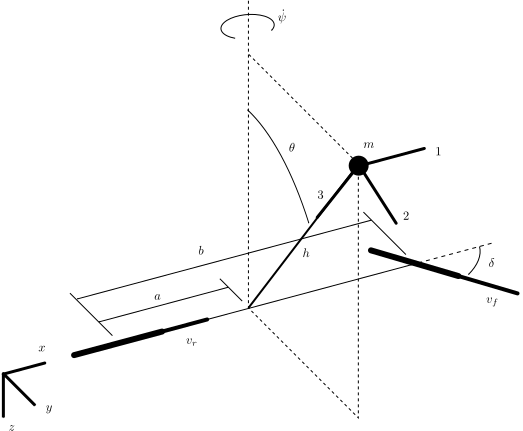

In [7]:
from IPython.display import SVG
SVG('model-diagram.svg')

with these variable definitions:

- $m$: Combined mass of the bicycle and the rider
- $h$: Height of the center of mass
- $a$: Distance from rear wheel to the projection of the center of mass
- $b$: Wheelbase
- $v_r,v_f$: Speed at rear and front wheels, respectively
- $g$: Acceleration due to gravity
- $I_1,I_2,I_3$: Principal moments of inertia of the combined bicycle and rider
- $\delta(t)$: Steering angle
- $\theta(t)$: Roll angle
- $\dot{\psi}(t)$: Heading angular rate

The non-linear equation of motion of this model can be written as so:

$$
(I_x + mh^2) \ddot{\theta} +
(I_3 - I_2 - mh^2)\left(\frac{v_r \tan\delta}{b}\right)^2 \sin\theta\cos\theta
-mgh\sin\theta
=-mh\cos\theta \left(\frac{av_r}{b\cos^2\delta}\dot{\delta}+\frac{v_r^2}{b}\tan{\delta}\right)
$$

The left hand side describes the natural roll dynamics and the right hand side gives the roll torque produced by steering. Additionally, the heading is dictated by this differential equation:

$$ \dot{\psi} = \frac{v_r}{b}\tan{\delta} $$

## Linearize the Model

The non-linear model presented above can be linearized about the upright equilibrium configuration ($\theta
=\delta=0$). The simplest method to put these equations into a linear form is to assume that all of the angles are small ($\approx0$). This means that $\sin\theta\approx\theta$, $\cos\theta\approx1$, $\cos\delta\approx1$, $\tan\delta\approx\delta$, and $\tan^2(\delta)\approx0$. With that assumption and defining $I=I_1$ and $v=v_r$the linear equation of motion can now be written as:

$$ (I + mh^2) \ddot{\theta} - mgh\theta = -\frac{mh}{b}\left(av\dot{\delta}+v^2\delta\right) $$

With $\theta$ as the output variable and $\delta$ as the input variable a transfer function can be created by transforming the above equation into the frequency domain:

$$ \frac{\theta(s)}{\delta(s)} = 
-\frac{mhv}{b} \frac{as + v}{(I + mh^2)s^2 - mgh}$$

The same can be done for the heading differential equation:

$$\dot{\psi}=\frac{v}{b}\delta$$

$$\frac{\psi(s)}{\delta(s)}= \frac{v}{bs}$$

# Dependency Installation

Before we begin designing the controller we will need to install some dependencies. The simplest way to get everything is to use [conda](http://conda.pydata.org/) and setup an environment with just the necessary packages:

```
$ conda create -n bicycle-control pip numpy scipy ipython-notebook
$ source activate bicycle-control
(bicycle-control)$ conda install -c https://conda.binstar.org/cwrowley slycot control
(bicycle-control)$ pip install plotly
```

In [1]:
import numpy as np
import control as cn
import plotly.plotly as pl
import plotly.graph_objs as gr

# Controller Design

At this point I will use the linear model as a foundation for a controller design. I will create a sequential dual-loop feedback controller which has an inner roll stabilization loop and an outer heading tracking loop. The final design will allow one to specify a desired heading of the bicycle. The structure of the controller is shown in the following block diagram:

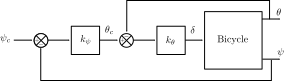

In [6]:
SVG('block-diagram.svg')

First, some reasonable numerical values for each of the model constants are specified.

In [2]:
g = 9.81  # m/s^2
m = 87.0  # kg
I = 3.28  # kg m^2
h = 1.0  # m
a = 0.5  # m
b = 1.0  # m
v = 5.0  # m/s

The Python Control package has a transfer function object that I will use to define all of the transfer functions needed in the control design. The first transfer function to specify is the plant's steer to roll relationship, $\frac{\theta(s)}{\delta(s)}$. This transfer function provides a second order linear relationship relating the roll angle of the bicycle, $\theta$, to the steering angle, $\delta$, and the inner loop controller designed around this transfer function will ensure that the bicycle can follow a commanded roll angle.

In [3]:
num = -m * h * v / b * np.array([a, v])
den = np.array([(I + m * h**2), 0.0, -m * g * h])
theta_delta = cn.TransferFunction(num, den)
theta_delta


 -217.5 s - 2175
-----------------
90.28 s^2 - 853.5

The first thing one may ask is whether or not the open loop system is stable? It is fairly obvious from the denominator of the transfer function (i.e. the characteristic equation), but we can use the `.pole()` method of a transfer function to compute the roots of the characteristic equation. If any of the poles have positive real parts, then I know the system is unstable.

In [4]:
theta_delta.pole()

array([-3.0746689,  3.0746689])

Now I see clearly that we have a pair of real poles, where one is positive, indicating that our system is unstable. This is identical to the behavior of a simple inverted pendulum.

The next thing that may be of interest is the step response of the system. I know that the system is unstable but the step response can possibly reveal other information. I will use the control toolbox's `forced_response` function so that we can control the magnitude of the step input. We will simulate the system for 5 seconds and set a step input of 2 degrees.

In [5]:
time = np.linspace(0.0, 5.0, num=1001)

In [6]:
delta = np.deg2rad(2.0) * np.ones_like(time)

In [7]:
time, theta, state = cn.forced_response(theta_delta, T=time, U=delta)

Now, I'll create a reusable function for plotting a SISO input/output time history.

In [8]:
def plot_siso_response(time, input, output, title='Time Response',
                       x_lab='Time [s]', x_lim=None,
                       input_y_lab='Input', input_y_lim=None,
                       output_y_lab='Output', output_y_lim=None,
                       subplots=True):
    """Plots a time history of the input and output of a SISO system."""
    
    xaxis = gr.XAxis(title=x_lab, range=x_lim)
    
    if subplots:
        yaxis = gr.YAxis(title=input_y_lab, range=input_y_lim, domain=[0.0, 0.49])
        yaxis2 = gr.YAxis(title=output_y_lab, range=output_y_lim, domain=[0.51, 1.0])
        layout = gr.Layout(title=title, xaxis=xaxis, yaxis=yaxis, yaxis2=yaxis2, showlegend=False)
        
        output_trace = gr.Scatter(name=output_y_lab, x=time, y=output, yaxis='y2')
    else:
        yaxis = gr.YAxis(range=output_y_lim)
        layout = gr.Layout(title=title, xaxis=xaxis, yaxis=yaxis)
        
        output_trace = gr.Scatter(name=output_y_lab, x=time, y=output)

    input_trace = gr.Scatter(name=input_y_lab, x=time, y=input)

    data = gr.Data([input_trace, output_trace])
    
    fig = gr.Figure(data=data, layout=layout)
    
    return fig

The simulation of the system's response to a positive step input of 2 degrees in steering is shown below. This plot shows that if you apply a positive steer angle, the roll angle exponentially grows in the negative direction. So forcing the steering to the right will make you fall to the left. This is opposite of what one finds in most vehicles. Typically steering to the right causes you to go to the right. This peculiarity will influence the controller design.

In [9]:
pl.iplot(plot_siso_response(time, np.rad2deg(delta),np.rad2deg(theta), title='Step Response',
                            output_y_lab='Roll Angle [deg]', input_y_lab='Steer Angle [deg]'))

Now it may be interesting to see if a simple proportional controller can stabilize this model and what kind of gain value is needed to do so. One way to do this is to compute the root locus of the closed loop system with a varying gain. A root locus is most informative as a plot on the imaginary/real plane, so here we define a function that will plot the roots as a function of the varying gain.

In [10]:
def plot_root_locus(gains, roots):
    """Plots the root locus of the closed loop system given the provided gains."""
    
    real_vals = np.real(roots)
    imag_vals = np.imag(roots)
    
    xaxis = gr.XAxis(title='Re')
    yaxis = gr.YAxis(title='Im')
    layout = gr.Layout(title='Root Locus', showlegend=False,
                       xaxis=xaxis, yaxis=yaxis)
    
    # plots a blue "x" for the first roots
    open_loop_poles = gr.Scatter(x=real_vals[0, :],
                                 y=imag_vals[0, :],
                                 marker=gr.Marker(symbol='x', color='blue'),
                                 mode='markers')
    
    # plots a red "o" for the last roots
    last_poles = gr.Scatter(x=real_vals[-1, :],
                            y=imag_vals[-1, :],
                            marker=gr.Marker(symbol='o', color='red'),
                            mode='markers')
    data = []
    
    gain_text = ['k = {:1.2f}'.format(k) for k in gains]
    
    for r, i in zip(real_vals.T, imag_vals.T):
        data.append(gr.Scatter(x=r, y=i, text=gain_text,
                               marker=gr.Marker(color='black'), mode="markers"))
                
    data.append(open_loop_poles)
    data.append(last_poles)
    
    return gr.Figure(data=gr.Data(data), layout=layout)

The root locus can be computed with Python Control's `root_locus` function. Let's see if various negative feedback gains will stabilize the system.

In [11]:
neg_feedback_roots, neg_feedback_gains = cn.root_locus(theta_delta, kvect=np.linspace(0.0, 10.0, num=500))

The root locus shows that for increasing negative feedback gains the bicycle will simply fall over even faster. (Use the "Show closest data on hover" option in the Plotly graph and hover over the traces to see the value of the gain.) I already know that the right steer makes the bicycle fall to the left. So if the bicycle is falling to the left a positive error causes steering to the right! Which, of course, causes the bicycle to fall over even faster. So what if I use positive feedback instead?

In [12]:
pl.iplot(plot_root_locus(neg_feedback_gains, neg_feedback_roots))

Now this is much better. It seems that if positive feedback is applied the system can indeed be stabilized by the controller. So if one commands a roll angle the bicycle must steer in the same direction to obtain that roll angle. This proves that we must steer into the fall in order to keep a bicycle upright.

In [13]:
pos_feedback_roots, pos_feedback_gains = cn.root_locus(theta_delta, kvect=np.linspace(0.0, -20.0, num=500))
pl.iplot(plot_root_locus(pos_feedback_gains, pos_feedback_roots))

Now that I know I can stabilize the system with positive feedback based on the roll angle error, I can choose a suitable controller that will allow me to command a roll angle and the bicycle will follow. The ability to command a roll angle is the first step to commanding a heading. For example, to head in the right direction the bicycle must eventually be steered and rolled to the right. So if I can command a rightward roll I am one step away from commanding a rightward turn.

Note that our system is a Type 0 system, thus a simple proportional feedback system will stabilize the system but there will be some steady state error. If better performance is required for the inner loop control, a different compensator (e.g. PID) would be needed. But since I am developing a sequential dual-loop controller that will not be necessary.

Below I define a function that generates the closed loop transfer function of a basic feedback system:

In [14]:
def feedback(plant, controller):
    """Returns the closed loop system given the plant and controller of this form:
    
      +    -----   -----
    -->o-->| c |-->| p |--->
      -|   -----   ----- |
       -------------------
    
    """
    feedforward = controller * plant
    return (feedforward / (1 + feedforward)).minreal()

Based on the root locus plot I choose a positive feedback gain that stabilizes the roll loop and generate the closed loop transfer function $\frac{\theta}{\theta_c}$.

In [15]:
k_theta = -2.5

In [16]:
theta_thetac = feedback(theta_delta, k_theta)
theta_thetac


   6.023 s + 60.23
---------------------
s^2 + 6.023 s + 50.78

Now the closed loop system is stable and has the expected oscillatory roots:

In [17]:
theta_thetac.pole()

array([-3.01146433+6.45807869j, -3.01146433-6.45807869j])

The closed inner loop attempts to track a commanded roll angle, $\theta_c$, and one can see how well it does that by looking at the step response. Below I command a 3 degree roll angle. Note that I get the expected steady state error with this simple controller. I could add a more complex compensator, such as a PID controller, to improve the performance of the roll control, but since I am ultimately concerned with heading control I'll leave this inner loop control as it is and will tune the performance of the heading control with the outer loop.

In [18]:
thetac = np.deg2rad(3.0) * np.ones_like(time)
time, theta, state = cn.forced_response(theta_thetac, T=time, U=thetac)

In [19]:
pl.iplot(plot_siso_response(time, np.rad2deg(thetac), np.rad2deg(theta),
                            input_y_lab='Commanded Roll Angle [deg]',
                            output_y_lab='Roll Angle [deg]', subplots=False))

I can now examine the steer angle needed to produce this roll behavior. It is interesting to note here that a positive commanded roll angle requires an initial negative steer angle that settles into a positive steer angle at steady state. So, to roll the bicycle in a desired direction, the controller must steer initially in the opposite direction. The following response shows the input and output traces of the roll controller block.

In [20]:
thetae = thetac - theta
delta = k_theta * thetae

In [21]:
pl.iplot(plot_siso_response(time, np.rad2deg(thetae), np.rad2deg(delta),
                           input_y_lab='Roll Error [deg]',
                           output_y_lab='Steer Angle [deg]'))

The next step is to close the outer heading tracking loop. To do this I need a new "plant" transfer function that represents the linear relationship between the commanded roll angle, $\theta_c$, and the heading angle, $\psi$, which will be fed back to close the outer loop. This transfer function can be found using this relationship:

$$ \frac{\psi(s)}{\theta_c(s)} = \frac{\theta(s)}{\theta_c(s)} \frac{\delta(s)}{\theta(s)} \frac{\psi(s)}{\delta(s)} $$

In [22]:
theta_thetac


   6.023 s + 60.23
---------------------
s^2 + 6.023 s + 50.78

In [23]:
delta_theta = cn.TransferFunction(theta_delta.den, theta_delta.num)
delta_theta


90.28 s^2 - 853.5
-----------------
 -217.5 s - 2175

In [24]:
psi_delta = cn.TransferFunction([v], [b, 0])
psi_delta


5
-
s

In [25]:
psi_thetac = (theta_thetac * delta_theta * psi_delta).minreal()
psi_thetac


-12.5 s^2 - 1.665e-14 s + 118.2
-------------------------------
   s^3 + 6.023 s^2 + 50.78 s

Since the heading transfer function is an integrator, a pole is introduced at the origin that makes the system marginally stable and now a Type 1 system. This pole will be an issue for stability but it also means that our system will not have any steady state error for a step response with a simple control gain.

In [26]:
psi_thetac.pole()

array([-3.01146433+6.45807869j, -3.01146433-6.45807869j,  0.00000000+0.j        ])

It is also interesting to check out the zeros of the system. The zeros dictate how the system responds to various inputs. In particular, there are a pair of zeros where one is in the right half plane. Right half plane zeros indicate that the system is a "[non-minimum phase system](https://en.wikipedia.org/wiki/Minimum_phase#Non-minimum_phase)" and the consequences of systems like these are very interesting. A single right half plane zero will cause the response to initially go in the "wrong" direction. This is an inherent property of a bicycle and it forces the rider to "[countersteer](https://en.wikipedia.org/wiki/Countersteering)" when they want to initiate a turn. This property makes bicycles fundamentally different than typical automobiles, boats, etc.

In [27]:
psi_thetac.zero()

array([-3.0746689,  3.0746689])

It is possible to see this phenomena by simulating the step response of $\frac{\psi(s)}{\theta_c}$. Notice that to command a rightward roll angle, the heading is initially directed to the left before it gets into a steady turn.

In [28]:
time, psi, state = cn.forced_response(psi_thetac, T=time, U=thetac)

In [29]:
pl.iplot(plot_siso_response(time, np.rad2deg(thetac), np.rad2deg(psi),
                            title="Step Response", output_y_lab='Heading Angle [deg]',
                            input_y_lab='Commanded Roll Angle [deg]'))

To close the heading loop, so that I can command a heading angle, I will use the root locus technique once more.

In [30]:
roots, gains = cn.root_locus(psi_thetac, kvect=np.linspace(0.0, 3.0, num=1001))

In [31]:
pl.iplot(plot_root_locus(gains, roots))

I will need negative feedback here to move the pole from the origin further into the left half plane, but too much gain will destabilize the oscillatory root.

In [32]:
k_psi = 0.25
psi_psic = feedback(psi_thetac, k_psi)
psi_psic.minreal()


 -3.125 s^2 + 1.388e-15 s + 29.54
---------------------------------
s^3 + 2.898 s^2 + 50.78 s + 29.54

In [33]:
psi_psic.pole()

array([-1.14995336+6.93382365j, -1.14995336-6.93382365j, -0.59802194+0.j        ])

Now the following plot shows the closed loop system's ability to track a command heading angle of 10 degrees.

In [34]:
psic = np.deg2rad(10.0) * np.ones_like(time)
time, psi, state = cn.forced_response(psi_psic, T=time, U=psic)

In [35]:
pl.iplot(plot_siso_response(time, np.rad2deg(psic), np.rad2deg(psi),
                            input_y_lab="Commanded Heading [deg]",
                            output_y_lab="Heading [deg]",
                            subplots=False))

Finally, to really see the counter steering effect during this simulation I will plot the steering input alongside both the roll and heading outputs.

In [36]:
psie = psic - psi
thetac = k_psi * psie
time, theta, state = cn.forced_response(theta_thetac, T=time, U=thetac)
thetae = thetac - theta
delta = k_theta * thetae

In [37]:
xaxis = gr.XAxis(title='Time [s]')
    
yaxis = gr.YAxis(title='Steer [deg]', domain=[0.0, 0.32])
yaxis2 = gr.YAxis(title='Roll [deg]', domain=[0.33, 0.65])
yaxis3 = gr.YAxis(title='Heading [deg]', domain=[0.66, 1.0])

layout = gr.Layout(title='Commanded Heading Response', showlegend=False,
                   xaxis=xaxis, yaxis=yaxis, yaxis2=yaxis2, yaxis3=yaxis3)

steer_trace = gr.Scatter(x=time, y=np.rad2deg(delta))
roll_trace = gr.Scatter(x=time, y=np.rad2deg(theta), yaxis='y2')
heading_trace = gr.Scatter(x=time, y=np.rad2deg(psi), yaxis='y3')
commanded_heading_trace = gr.Scatter(x=time, y=np.rad2deg(psic), yaxis='y3')

data = gr.Data([steer_trace, roll_trace, heading_trace, commanded_heading_trace])
    
fig = gr.Figure(data=data, layout=layout)

pl.iplot(fig)

This final plot shows the closed loop step response to a commanded rightward heading angle of 10 degrees. It is clear that one must initially steer about 5 degrees to the left causing a roll to the right to make the rightward change in heading. 

# Conclusion

This notebook demonstrates one way to design a controller for a linear model of a bicycle. The controller shown is probably the simplest controller for tracking heading and the gains can certainly be tuned for different performance metrics. I made use of the Python Control library and the root locus design tool to find two suitable gains for the sequential dual-loop controller. Finally, simulation of the closed loop system gave very clear demonstration of the inherent need for countersteering to effectively control the vehicle.

### About the author
Jason K. Moore is a postdoctoral researcher at the Cleveland State University [Human Motion & Control Lab](http://hmc.csuohio.edu/) where he works on identification of human walking control strategies for use in powered prosthetic control design. He loves bicycles, so much so that he wrote a [dissertation](http://moorepants.github.io/dissertation/) on the topic. You can find out more about him on his website: [moorepants.info](http://moorepants.info).

In [1]:
from IPython.display import display, HTML

display(HTML('<link href="//fonts.googleapis.com/css?family=Open+Sans:600,400,300,200|Inconsolata|Ubuntu+Mono:400,700" rel="stylesheet" type="text/css" />'))
display(HTML('<link rel="stylesheet" type="text/css" href="http://help.plot.ly/documentation/all_static/css/ipython-notebook-custom.css">'))


! pip install publisher --upgrade
import publisher
publisher.publish(
    'bicycle_control.ipynb', 'ipython-notebooks/bicycle-control-design/', 'Bicycle Control Design with Python and Plotly', 
    'Design of a sequential dual-loop controller for a bicycle using NumPy, SciPy, Python Control, and Plotly.', name='Bicycle Control Design')

Requirement already up-to-date: publisher in /Users/chelsea/venv/venv2.7/lib/python2.7/site-packages


/Users/chelsea/venv/venv2.7/lib/python2.7/site-packages/IPython/nbconvert.py:13: ShimWarning: The `IPython.nbconvert` package has been deprecated since IPython 4.0. You should import from nbconvert instead.
  "You should import from nbconvert instead.", ShimWarning)
/Users/chelsea/venv/venv2.7/lib/python2.7/site-packages/publisher/publisher.py:53: UserWarning: Did you "Save" this notebook before running this command? Remember to save, always save.
  warnings.warn('Did you "Save" this notebook before running this command? '
